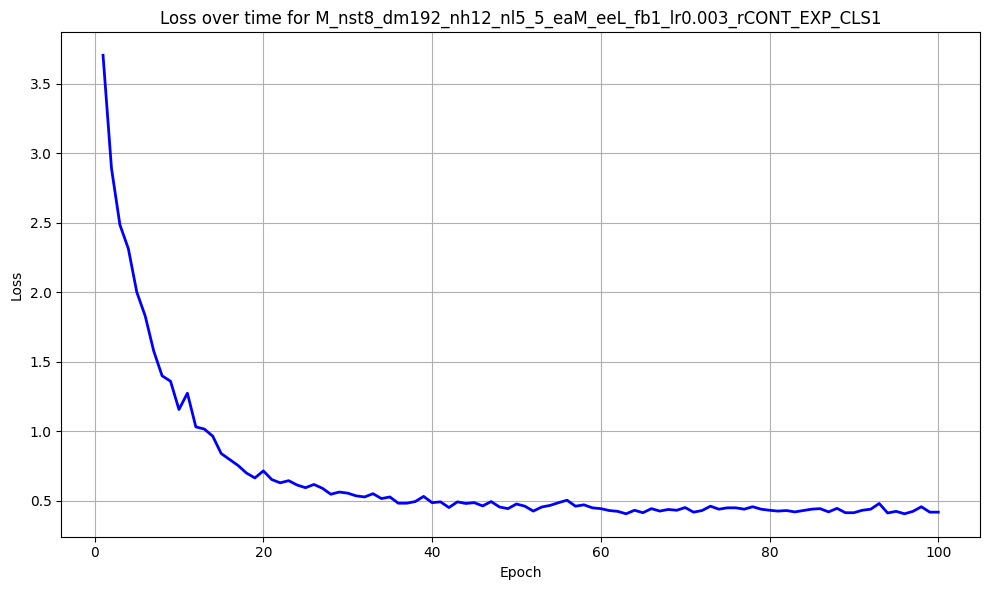

In [3]:
model_dirname = 'M_nst8_dm192_nh12_nl5_5_eaM_eeL_fb1_lr0.003_rCONT_EXP_CLS1'
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Load the training statistics from the JSON file
stats_path = os.path.join('models_data', model_dirname, 'training_statistics.json')

with open(stats_path, 'r') as f:
    training_stats = json.load(f)


losses = [x['test_loss'] for x in training_stats if 'test_loss' in x]
epochs = range(1, len(losses) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, 'b-', linewidth=2)
plt.title(f'Loss over time for {model_dirname}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# Set x-axis to logarithmic scale
#plt.xscale('log')


plt.tight_layout()
plt.show()


In [5]:
import torch

# Define the epoch number
n_epoch = 100

# Construct the model path
model_path = os.path.join('models_data', model_dirname, f'model_epoch_{n_epoch}.pth')

# Load the model dictionary
model_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Print the keys in the model dictionary
print("Keys in the model dictionary:")
for key in model_dict.keys():
    print(f"- {key}")


Keys in the model dictionary:
- eval_results
- epoch
- model_state_dict
- electrode_data_embeddings_state_dict
- optimizer_state_dicts
- training_config
- model_config
- cluster_config


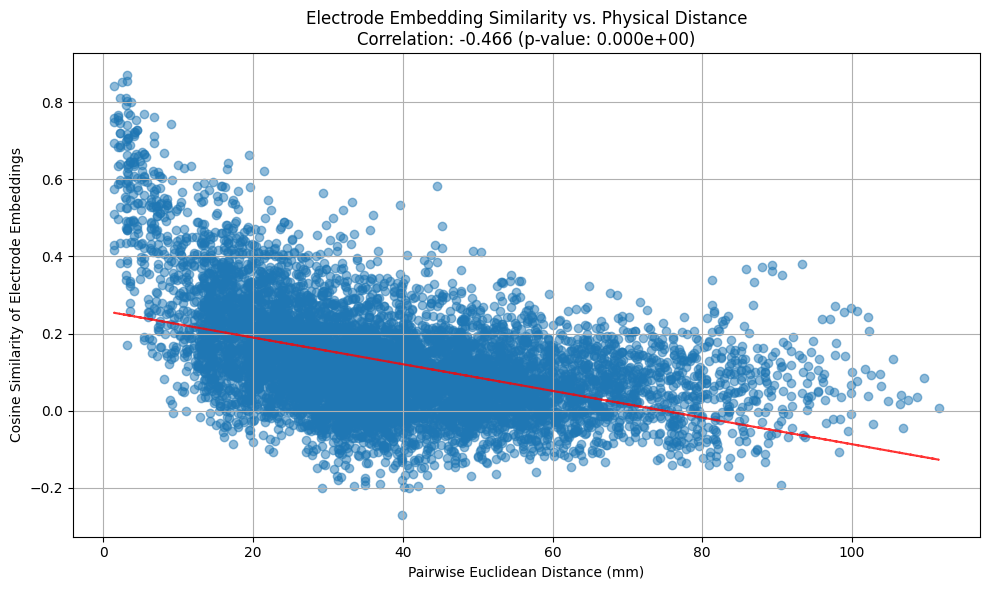

Number of electrode pairs: 8385
Correlation between distance and cosine similarity: -0.466
p-value: 0.000e+00


In [26]:
csubject_id = 1
from subject_braintreebank import BrainTreebankSubject
subject = BrainTreebankSubject(subject_id, cache=False)

electrode_embeddings = model_dict['electrode_data_embeddings_state_dict'][f'electrode_embedding_class.embeddings.btbank{subject_id}'].float()
electrode_coordinates = subject.get_electrode_coordinates().float()

# Calculate pairwise distances between electrode coordinates
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

# Convert tensors to numpy for easier manipulation
electrode_embeddings_np = electrode_embeddings.detach().numpy()
electrode_coordinates_np = electrode_coordinates.detach().numpy()

# Calculate pairwise Euclidean distances between electrode coordinates
n_electrodes = electrode_coordinates_np.shape[0]
pairwise_distances = []
pairwise_cosine_similarities = []

for i in range(n_electrodes):
    for j in range(i+1, n_electrodes):  # Only calculate unique pairs
        # Calculate Euclidean distance between coordinates
        dist = np.linalg.norm(electrode_coordinates_np[i] - electrode_coordinates_np[j])
        
        # Calculate cosine similarity between embeddings
        cos_sim = cosine_similarity(electrode_embeddings_np[i].reshape(1, -1), 
                                   electrode_embeddings_np[j].reshape(1, -1))[0][0]
        
        pairwise_distances.append(dist)
        pairwise_cosine_similarities.append(cos_sim)

# Convert to numpy arrays
pairwise_distances = np.array(pairwise_distances)
pairwise_cosine_similarities = np.array(pairwise_cosine_similarities)

# Calculate correlation
correlation, p_value = pearsonr(pairwise_distances, pairwise_cosine_similarities)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pairwise_distances, pairwise_cosine_similarities, alpha=0.5)
plt.title(f'Electrode Embedding Similarity vs. Physical Distance\nCorrelation: {correlation:.3f} (p-value: {p_value:.3e})')
plt.xlabel('Pairwise Euclidean Distance (mm)')
plt.ylabel('Cosine Similarity of Electrode Embeddings')

# Add a trend line
z = np.polyfit(pairwise_distances, pairwise_cosine_similarities, 1)
p = np.poly1d(z)
plt.plot(pairwise_distances, p(pairwise_distances), "r--", alpha=0.8)

plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of electrode pairs: {len(pairwise_distances)}")
print(f"Correlation between distance and cosine similarity: {correlation:.3f}")
print(f"p-value: {p_value:.3e}")


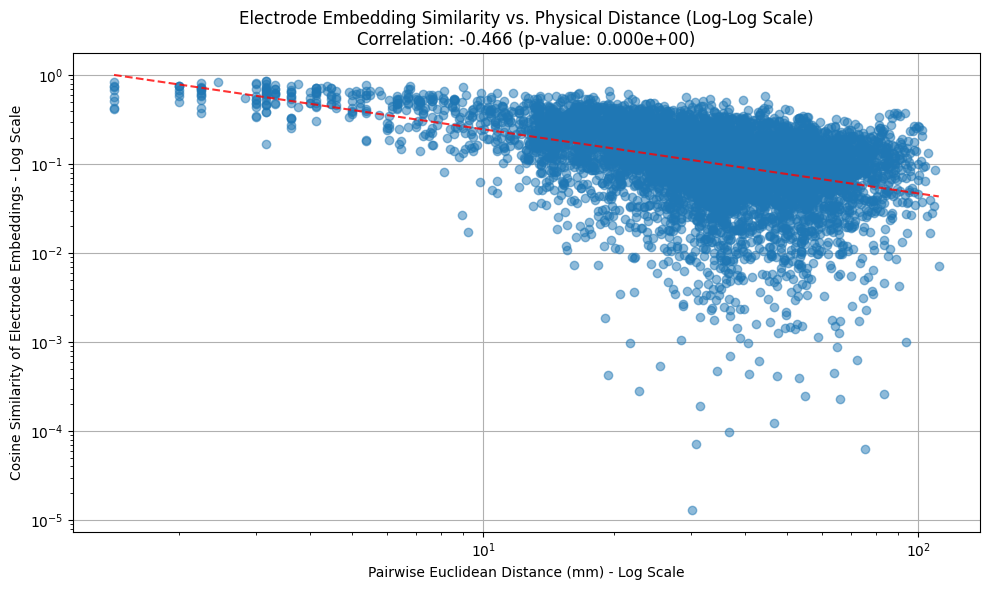

Number of electrode pairs: 8385
Correlation between distance and cosine similarity: -0.466
p-value: 0.000e+00


In [27]:
# Convert tensors to numpy for easier manipulation
electrode_embeddings_np = electrode_embeddings.detach().numpy()
electrode_coordinates_np = electrode_coordinates.detach().numpy()

# Calculate pairwise Euclidean distances between electrode coordinates
n_electrodes = electrode_coordinates_np.shape[0]
pairwise_distances = []
pairwise_cosine_similarities = []

for i in range(n_electrodes):
    for j in range(i+1, n_electrodes):  # Only calculate unique pairs
        # Calculate Euclidean distance between coordinates
        dist = np.linalg.norm(electrode_coordinates_np[i] - electrode_coordinates_np[j])
        
        # Calculate cosine similarity between embeddings
        cos_sim = cosine_similarity(electrode_embeddings_np[i].reshape(1, -1), 
                                   electrode_embeddings_np[j].reshape(1, -1))[0][0]
        
        pairwise_distances.append(dist)
        pairwise_cosine_similarities.append(cos_sim)

# Convert to numpy arrays
pairwise_distances = np.array(pairwise_distances)
pairwise_cosine_similarities = np.array(pairwise_cosine_similarities)

# Calculate correlation
correlation, p_value = pearsonr(pairwise_distances, pairwise_cosine_similarities)

# Create the log-log scatter plot
plt.figure(figsize=(10, 6))
plt.loglog(pairwise_distances, pairwise_cosine_similarities, 'o', alpha=0.5)
plt.title(f'Electrode Embedding Similarity vs. Physical Distance (Log-Log Scale)\nCorrelation: {correlation:.3f} (p-value: {p_value:.3e})')
plt.xlabel('Pairwise Euclidean Distance (mm) - Log Scale')
plt.ylabel('Cosine Similarity of Electrode Embeddings - Log Scale')

# Add a trend line (in log-log space)
# We need to filter out any negative values since we can't take log of negative numbers
valid_indices = pairwise_cosine_similarities > 0
if np.sum(valid_indices) > 0:
    valid_distances = pairwise_distances[valid_indices]
    valid_similarities = pairwise_cosine_similarities[valid_indices]
    z = np.polyfit(np.log(valid_distances), np.log(valid_similarities), 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(valid_distances), max(valid_distances), 100)
    plt.loglog(x_range, np.exp(p(np.log(x_range))), "r--", alpha=0.8)

plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of electrode pairs: {len(pairwise_distances)}")
print(f"Correlation between distance and cosine similarity: {correlation:.3f}")
print(f"p-value: {p_value:.3e}")


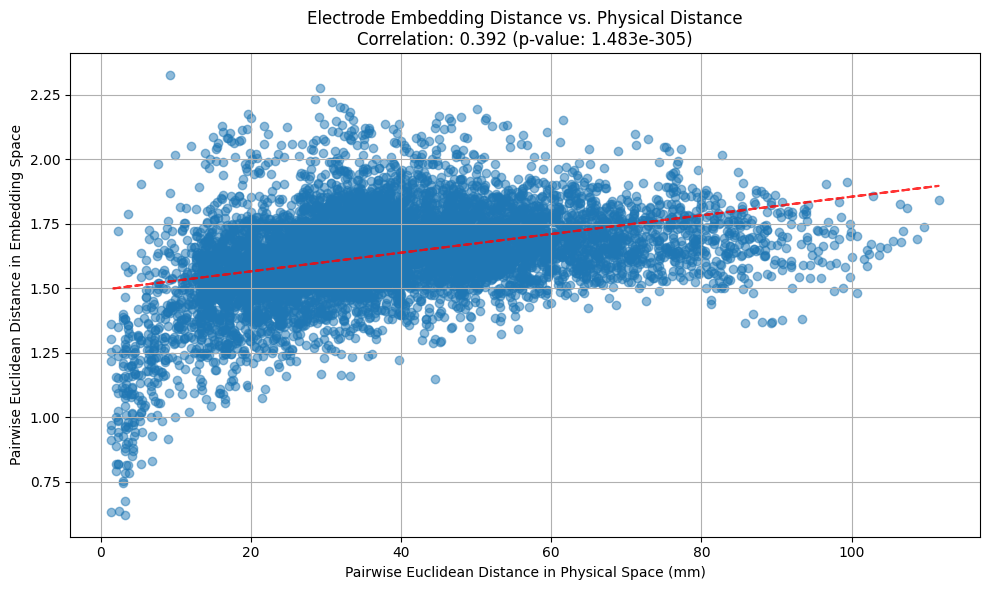

Number of electrode pairs: 8385
Correlation between physical distance and embedding distance: 0.392
p-value: 1.483e-305


In [24]:
# Calculate pairwise Euclidean distances between electrode coordinates
n_electrodes = electrode_coordinates_np.shape[0]
pairwise_distances = []
pairwise_embedding_distances = []

for i in range(n_electrodes):
    for j in range(i+1, n_electrodes):  # Only calculate unique pairs
        # Calculate Euclidean distance between coordinates
        dist = np.linalg.norm(electrode_coordinates_np[i] - electrode_coordinates_np[j])
        
        # Calculate Euclidean distance between embeddings
        embedding_dist = np.linalg.norm(electrode_embeddings_np[i] - electrode_embeddings_np[j])
        
        pairwise_distances.append(dist)
        pairwise_embedding_distances.append(embedding_dist)

# Convert to numpy arrays
pairwise_distances = np.array(pairwise_distances)
pairwise_embedding_distances = np.array(pairwise_embedding_distances)

# Calculate correlation
correlation, p_value = pearsonr(pairwise_distances, pairwise_embedding_distances)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pairwise_distances, pairwise_embedding_distances, alpha=0.5)
plt.title(f'Electrode Embedding Distance vs. Physical Distance\nCorrelation: {correlation:.3f} (p-value: {p_value:.3e})')
plt.xlabel('Pairwise Euclidean Distance in Physical Space (mm)')
plt.ylabel('Pairwise Euclidean Distance in Embedding Space')

# Add a trend line
z = np.polyfit(pairwise_distances, pairwise_embedding_distances, 1)
p = np.poly1d(z)
plt.plot(pairwise_distances, p(pairwise_distances), "r--", alpha=0.8)

plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of electrode pairs: {len(pairwise_distances)}")
print(f"Correlation between physical distance and embedding distance: {correlation:.3f}")
print(f"p-value: {p_value:.3e}")


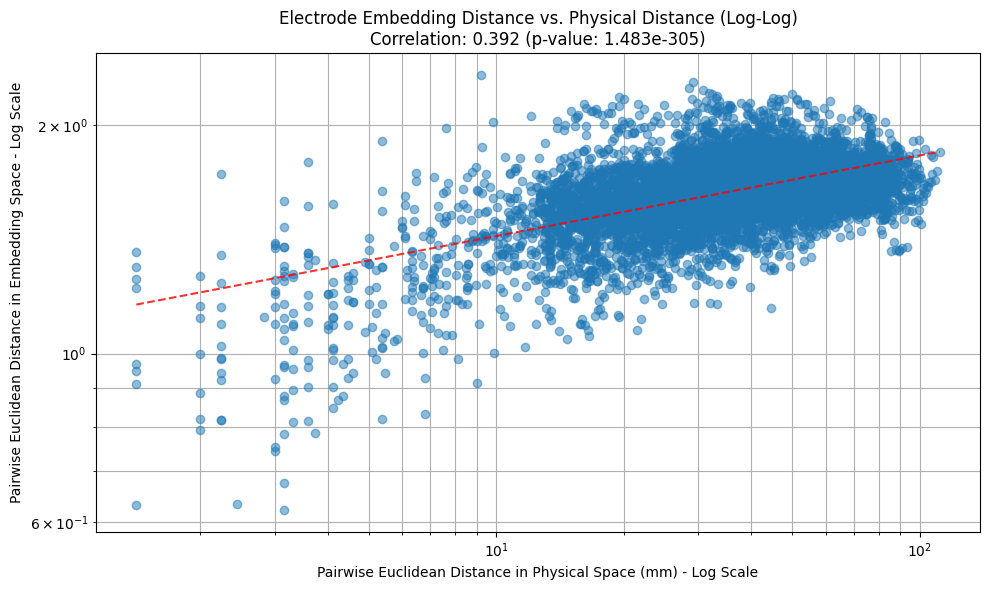

Number of electrode pairs: 8385
Correlation between physical distance and embedding distance: 0.392
p-value: 1.483e-305
Log-log slope: 0.106


In [25]:
# Calculate pairwise Euclidean distances between electrode coordinates
n_electrodes = electrode_coordinates_np.shape[0]
pairwise_distances = []
pairwise_embedding_distances = []

for i in range(n_electrodes):
    for j in range(i+1, n_electrodes):  # Only calculate unique pairs
        # Calculate Euclidean distance between coordinates
        dist = np.linalg.norm(electrode_coordinates_np[i] - electrode_coordinates_np[j])
        
        # Calculate Euclidean distance between embeddings
        embedding_dist = np.linalg.norm(electrode_embeddings_np[i] - electrode_embeddings_np[j])
        
        pairwise_distances.append(dist)
        pairwise_embedding_distances.append(embedding_dist)

# Convert to numpy arrays
pairwise_distances = np.array(pairwise_distances)
pairwise_embedding_distances = np.array(pairwise_embedding_distances)

# Calculate correlation
correlation, p_value = pearsonr(pairwise_distances, pairwise_embedding_distances)

# Create the log-log scatter plot
plt.figure(figsize=(10, 6))
plt.loglog(pairwise_distances, pairwise_embedding_distances, 'o', alpha=0.5)
plt.title(f'Electrode Embedding Distance vs. Physical Distance (Log-Log)\nCorrelation: {correlation:.3f} (p-value: {p_value:.3e})')
plt.xlabel('Pairwise Euclidean Distance in Physical Space (mm) - Log Scale')
plt.ylabel('Pairwise Euclidean Distance in Embedding Space - Log Scale')

# Add a trend line on log-log scale
log_distances = np.log(pairwise_distances)
log_embedding_distances = np.log(pairwise_embedding_distances)
z = np.polyfit(log_distances, log_embedding_distances, 1)
p = np.poly1d(z)

# Create x points for the trend line
x_log = np.linspace(min(log_distances), max(log_distances), 100)
x = np.exp(x_log)
y = np.exp(p(x_log))

plt.loglog(x, y, "r--", alpha=0.8)

plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.show()

print(f"Number of electrode pairs: {len(pairwise_distances)}")
print(f"Correlation between physical distance and embedding distance: {correlation:.3f}")
print(f"p-value: {p_value:.3e}")
print(f"Log-log slope: {z[0]:.3f}")
